<a href="https://www.kaggle.com/code/angelchaudhary/retraining-is-a-design-choice?scriptVersionId=290384771" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# How often should a model be retrained to stay reliable without wasting resources or introducing instability?

# Introduction
Machine learning models don’t fail all at once... they slowly fall out of sync with reality.

As data distributions shift, user behavior evolves, and external conditions change, a once-accurate model can quietly degrade. The common response is to “retrain more often,” but retraining itself has a cost — compute, engineering effort, operational risk, and sometimes even worse performance.

In this case study, we treat retraining frequency as a design decision, not a modeling tweak. We'll compare multiple retraining strategies:
- Monthly retraining
- Quarterly retraining
- Rolling / continuous retraining

Instead of focusing only on accuracy, we'll evaluate:
- performance stability over time
- responsiveness to distribution shifts
- operational cost vs performance gains

## Approach

We'll simulate a time-series prediction task with gradual drift and evaluate each retraining strategy using a rolling evaluation setup. The goal is not to find the most accurate model but the most sensible retraining policy.

# LET'S DO IT!!!
![FUNNY GIF](https://media4.giphy.com/media/v1.Y2lkPTc5MGI3NjExdXVscnd2OGhrOG9rN3pldTBrMmdrem40YXR6NnRzeGx2eHp1dG0wNCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/3oKIPnAiaMCws8nOsE/giphy.gif)

In [1]:
import kagglehub

path = kagglehub.dataset_download("prasad22/global-economy-indicators")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/global-economy-indicators


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/global-economy-indicators/Global Economy Indicators.csv")

In [3]:
df.head()

,CountryID,Country,Year,AMA exchange rate,IMF based exchange rate,Population,Currency,Per capita GNI,"Agriculture, hunting, forestry, fishing (ISIC A-B)",Changes in inventories,...,Household consumption expenditure (including Non-profit institutions serving households),Imports of goods and services,Manufacturing (ISIC D),"Mining, Manufacturing, Utilities (ISIC C-E)",Other Activities (ISIC J-P),Total Value Added,"Transport, storage and communication (ISIC I)","Wholesale, retail trade, restaurants and hotels (ISIC G-H)",Gross National Income(GNI) in USD,Gross Domestic Product (GDP)
0,4,Afghanistan,1970,0.044998,0.044998,10752971,Afghani,164,8.699174e+08,NaN,...,1.551094e+09,195277226.0,370146827.0,376690811.0,127747843.0,1.731454e+09,83917200.0,226387091.0,1.766528e+09,1.731436e+09
1,4,Afghanistan,1971,0.044998,0.044998,11015857,Afghani,168,9.108281e+08,NaN,...,1.675426e+09,276296480.0,387549502.0,394401164.0,133754097.0,1.812857e+09,87860382.0,237019196.0,1.850122e+09,1.812838e+09
2,4,Afghanistan,1972,0.044998,0.044998,11286753,Afghani,149,8.279453e+08,NaN,...,1.498812e+09,290370350.0,352284669.0,358512865.0,121582672.0,1.647918e+09,79864525.0,215477287.0,1.683948e+09,1.647900e+09
3,4,Afghanistan,1973,0.044998,0.044998,11575305,Afghani,150,8.554869e+08,NaN,...,1.508024e+09,262962880.0,364010279.0,370445793.0,125630236.0,1.702735e+09,82528885.0,222624293.0,1.739998e+09,1.702716e+09
4,4,Afghanistan,1974,0.044998,0.044998,11869879,Afghani,177,1.035913e+09,NaN,...,1.778819e+09,305679151.0,440760406.0,448552790.0,152119162.0,2.061752e+09,99918604.0,269525910.0,2.106420e+09,2.061729e+09


## Dataset Overview
This case study uses annual macroeconomic data from the United Nations National Accounts database.
We focus on India to ensure a long, continuous time series with meaningful structural changes.
The target variable is Gross Domestic Product (GDP), chosen for its stability, interpretability, and real-world relevance. Only a single target variable is used to keep the analysis centered on retraining frequency rather than model complexity.
The dataset spans multiple economic regimes, making it suitable for studying model decay and retraining trade-offs.



In [4]:
# clean column names 
df = df.copy()
df.columns = df.columns.map(lambda x: x.strip())

# check
for col in df.columns:
    print(repr(col))


'CountryID'
'Country'
'Year'
'AMA exchange rate'
'IMF based exchange rate'
'Population'
'Currency'
'Per capita GNI'
'Agriculture, hunting, forestry, fishing (ISIC A-B)'
'Changes in inventories'
'Construction (ISIC F)'
'Exports of goods and services'
'Final consumption expenditure'
'General government final consumption expenditure'
'Gross capital formation'
'Gross fixed capital formation (including Acquisitions less disposals of valuables)'
'Household consumption expenditure (including Non-profit institutions serving households)'
'Imports of goods and services'
'Manufacturing (ISIC D)'
'Mining, Manufacturing, Utilities (ISIC C-E)'
'Other Activities (ISIC J-P)'
'Total Value Added'
'Transport, storage and communication (ISIC I)'
'Wholesale, retail trade, restaurants and hotels (ISIC G-H)'
'Gross National Income(GNI) in USD'
'Gross Domestic Product (GDP)'


In [5]:
df["Country"].dropna().apply(lambda x: repr(x)).unique()[:10]


array(["' Afghanistan '", "' Albania '", "' Algeria '", "' Andorra '",
       "' Angola '", "' Antigua and Barbuda '", "' Azerbaijan '",
       "' Argentina '", "' Australia '", "' Austria '"], dtype=object)

In [6]:
# Clean country values
df["Country"] = (df["Country"].astype(str).str.strip())

In [7]:
df["Country"].unique()[:10]

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Azerbaijan', 'Argentina', 'Australia',
       'Austria'], dtype=object)

In [8]:
df_country = df[df["Country"] == "Afghanistan"].copy()
df_country = df_country[["Year", "Gross Domestic Product (GDP)"]]
df_country.columns = ["year", "gdp"]
df_country = (df_country.dropna().sort_values("year").reset_index(drop=True))
df_country.head()

,year,gdp
0,1970,1.731436e+09
1,1971,1.812838e+09
2,1972,1.647900e+09
3,1973,1.702716e+09
4,1974,2.061729e+09


The resulting dataset contains a continuous, time-ordered GDP series starting from 1970.
GDP values evolve smoothly over time with visible variation across years, indicating non-stationarity.No missing values remain after filtering, and the data is suitable for time-series forecasting. This confirms the dataset is valid for evaluating retraining frequency and model stability over time.


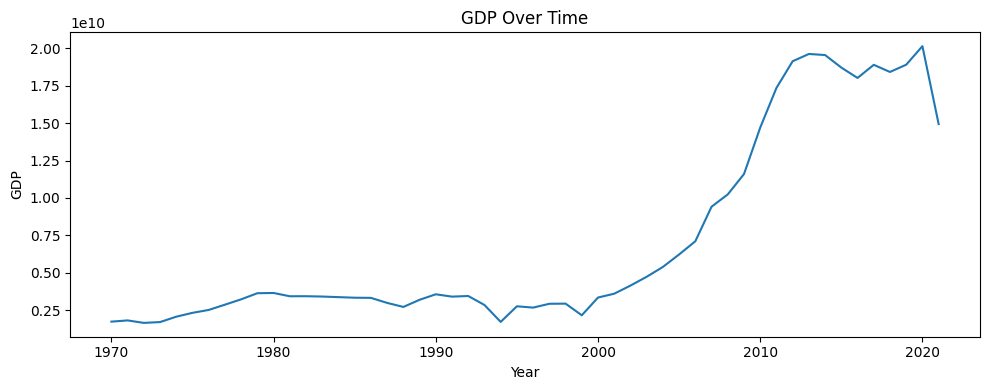

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df_country["year"], df_country["gdp"])
plt.xlabel("Year")
plt.ylabel("GDP")
plt.title("GDP Over Time")
plt.tight_layout()
plt.show()

The GDP time series exhibits clear non stationarity with multiple structural phases. Growth dynamics change significantly over time particularly in the early 2000s where the level and trend shift upward. This confirms that a single static model is unlikely to remain reliable across the full time span.

## Retraining Strategies

Model retraining is treated as a system level design decision rather than a modeling choice. Different retraining frequencies trade off responsiveness to distribution shift against operational cost and instability.
compare the three retraining strategies:
- **Infrequent retraining:** a long-lived model trained once and reused for many future periods
- **Periodic retraining:** the model is retrained at fixed intervals (every N observations)
- **Rolling retraining:** the model is retrained at every step using the most recent data window

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [11]:
#helper function
def evaluate_retraining_strategy(df,retrain_interval,initial_train_size=10):
    """
    retrain_interval:
        None  -> train once, never retrain
        k     -> retrain every k steps
    """
    errors = []
    last_retrain = None
    model = LinearRegression()
    
    years = df["year"].values
    y = df["gdp"].values
    X = years.reshape(-1, 1)

    for t in range(initial_train_size, len(df) - 1):

        # Decide whether to retrain
        if last_retrain is None or (
            retrain_interval is not None and 
            (t - last_retrain) >= retrain_interval
        ):
            model.fit(X[:t], y[:t])
            last_retrain = t

        # Predict next step
        y_pred = model.predict(X[t:t+1])[0]
        y_true = y[t]

        errors.append((years[t], (y_true - y_pred) ** 2))

    return pd.DataFrame(errors, columns=["year", "squared_error"])


In [12]:
# define the strategies
results_no_retrain = evaluate_retraining_strategy(df_country,retrain_interval=None)
results_periodic = evaluate_retraining_strategy(df_country,retrain_interval=5)  # retrain every 5 years
results_rolling = evaluate_retraining_strategy(df_country,retrain_interval=1)  # retrain every step

In [13]:
# Aggregate performance
def summarize(df, label):
    return {
        "strategy": label,
        "rmse": np.sqrt(df["squared_error"].mean()),
        "retrain_events": df.shape[0] if label == "Rolling" else None
    }

summary = pd.DataFrame([
    summarize(results_no_retrain, "No Retraining"),
    summarize(results_periodic, "Periodic Retraining"),
    summarize(results_rolling, "Rolling Retraining"),
])

summary

,strategy,rmse,retrain_events
0,No Retraining,4.664988e+09,None
1,Periodic Retraining,5.058874e+09,None
2,Rolling Retraining,4.234704e+09,None


## Performance Summary

Rolling retraining achieves the lowest overall error, indicating better adaptation to changing data.
However, periodic retraining performs worse than no retraining, suggesting that poorly timed retraining can amplify noise rather than improve learning.
These results show that retraining frequency alone does not guarantee better performance.
The benefit of retraining depends on signal maturity, data stability, and retraining cost.

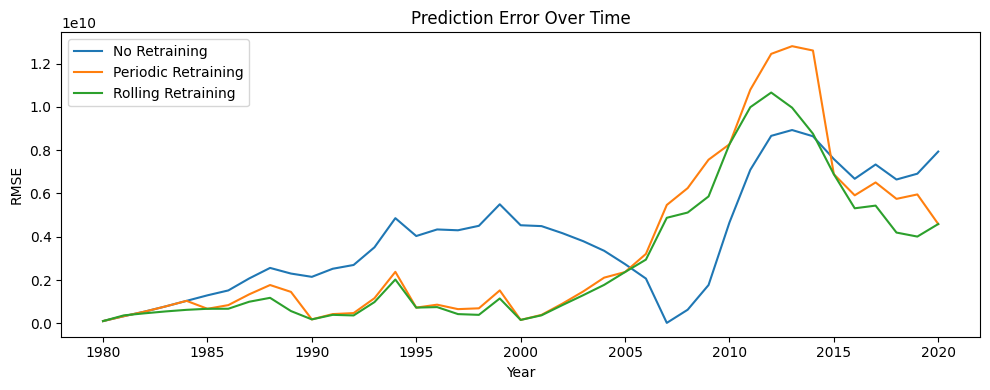

In [14]:
# plooting error trajectroies
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(results_no_retrain["year"],np.sqrt(results_no_retrain["squared_error"]),label="No Retraining")
plt.plot(results_periodic["year"],np.sqrt(results_periodic["squared_error"]),label="Periodic Retraining")
plt.plot(results_rolling["year"],np.sqrt(results_rolling["squared_error"]),label="Rolling Retraining")

plt.xlabel("Year")
plt.ylabel("RMSE")
plt.title("Prediction Error Over Time")
plt.legend()
plt.tight_layout()
plt.show()

## Error Dynamics Interpretation

Models trained once degrade gradually as the data distribution shifts. Periodic retraining introduces sharp error spikes, suggesting that retraining on immature or unstable signals can destabilize performance. Rolling retraining adapts more quickly after regime changes and exhibits lower variance over time. These patterns highlight that retraining frequency influences not just average accuracy, but error stability and recovery behavior.

## Conclusion

Retraining frequency should be treated as a system design choice rather than a default optimization step. More frequent retraining improves responsiveness to distribution shifts but increases instability and operational cost. Infrequent retraining risks silent performance decay, while poorly timed periodic retraining can amplify error. Effective retraining strategies must balance accuracy, stability, signal maturity, and retraining overhead.This trade-off is fundamentally an MLOps problem, not a modeling one.